
=== Logistic (balanced) @ threshold=0.50 ===
              precision    recall  f1-score   support

           0      0.986     0.743     0.847       972
           1      0.138     0.800     0.235        50

    accuracy                          0.746      1022
   macro avg      0.562     0.771     0.541      1022
weighted avg      0.945     0.746     0.817      1022



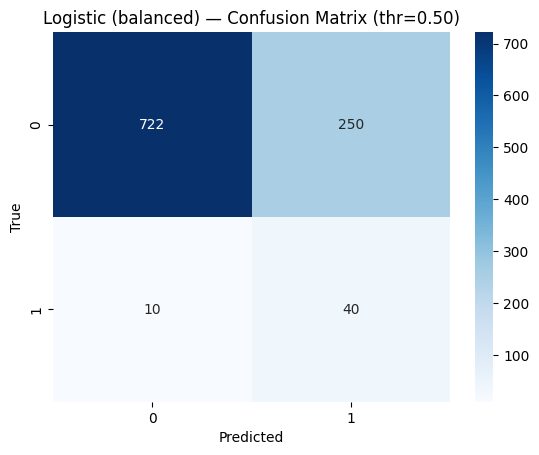


=== Logistic (balanced) @ threshold=0.73 ===
              precision    recall  f1-score   support

           0      0.983     0.873     0.925       972
           1      0.222     0.700     0.337        50

    accuracy                          0.865      1022
   macro avg      0.602     0.787     0.631      1022
weighted avg      0.945     0.865     0.896      1022



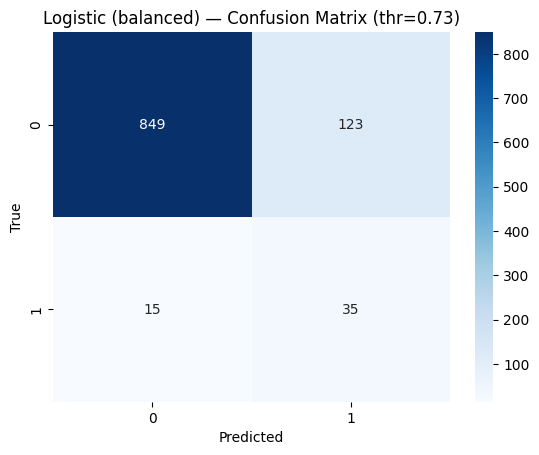


=== RandomForest + SMOTE @ threshold=0.50 ===
              precision    recall  f1-score   support

           0      0.955     0.968     0.962       972
           1      0.162     0.120     0.138        50

    accuracy                          0.927      1022
   macro avg      0.559     0.544     0.550      1022
weighted avg      0.917     0.927     0.921      1022



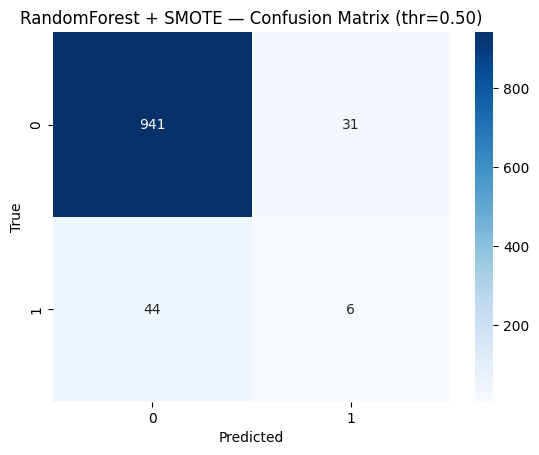


=== RandomForest + SMOTE @ threshold=0.09 ===
              precision    recall  f1-score   support

           0      0.986     0.701     0.819       972
           1      0.121     0.800     0.210        50

    accuracy                          0.705      1022
   macro avg      0.553     0.750     0.514      1022
weighted avg      0.943     0.705     0.789      1022



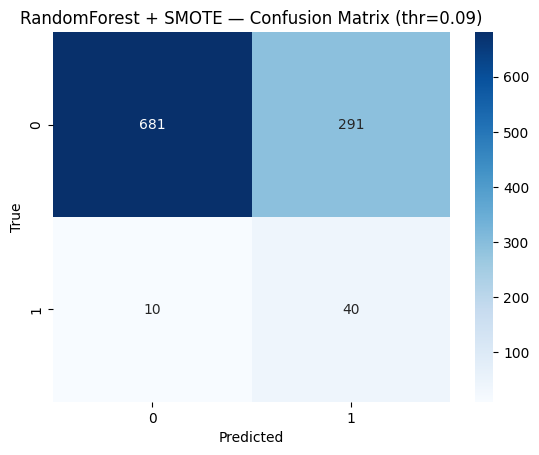


=== XGBoost (SPW) @ threshold=0.50 ===
              precision    recall  f1-score   support

           0      0.969     0.918     0.942       972
           1      0.208     0.420     0.278        50

    accuracy                          0.893      1022
   macro avg      0.588     0.669     0.610      1022
weighted avg      0.931     0.893     0.910      1022



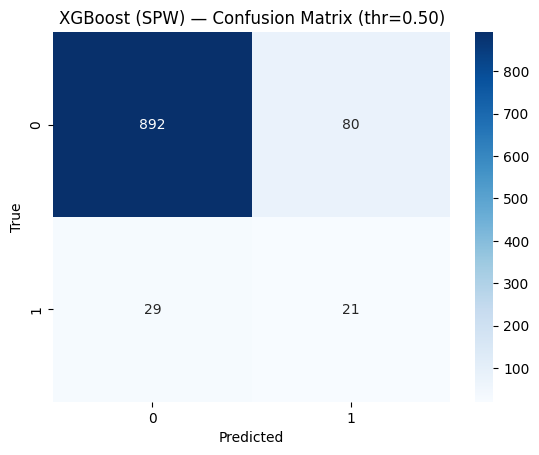


=== XGBoost (SPW) @ threshold=0.27 ===
              precision    recall  f1-score   support

           0      0.977     0.833     0.900       972
           1      0.161     0.620     0.255        50

    accuracy                          0.823      1022
   macro avg      0.569     0.727     0.577      1022
weighted avg      0.937     0.823     0.868      1022



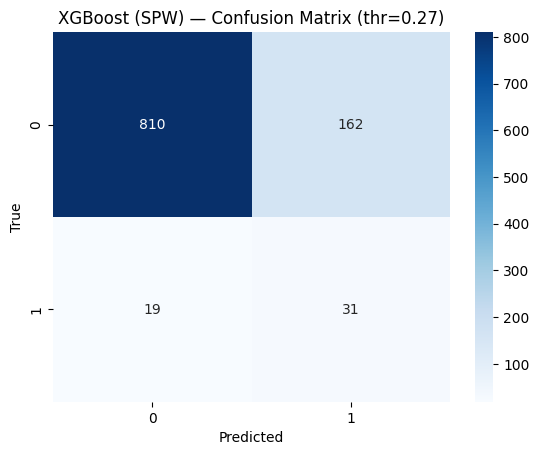

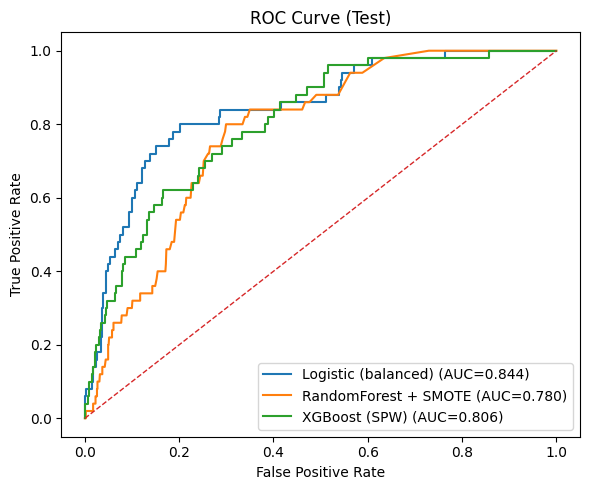

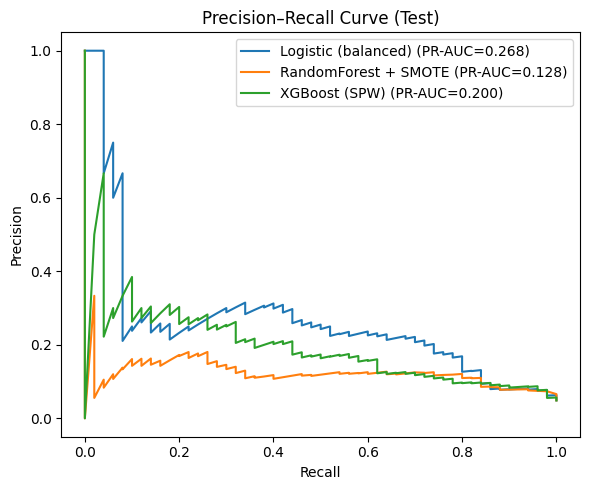


Saved metrics to: reports/model_metrics.csv


In [3]:
# STEP 5: Train, handle imbalance, evaluate, and compare three models
# Models: Logistic Regression (class_weight), RandomForest (+SMOTE), XGBoost (scale_pos_weight)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve, f1_score)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# If xgboost isn't installed, run: pip install xgboost
from xgboost import XGBClassifier

# ---------- Load cleaned data ----------
DATA_PATH = Path("../data/stroke_clean.csv")  # adjust if different
df = pd.read_csv(DATA_PATH)

target = "stroke"
feature_columns = [
    "gender","age","hypertension","heart_disease","ever_married",
    "work_type","Residence_type","avg_glucose_level","bmi","smoking_status"
]
X = df[feature_columns].copy()
y = df[target].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# ---------- Preprocessing (leak-proof) ----------
numeric_features = ["age","avg_glucose_level","bmi"]
categorical_features = list(set(feature_columns) - set(numeric_features))

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer([
    ("num", num_pipeline, numeric_features),
    ("cat", cat_pipeline, categorical_features),
])

# ---------- Class imbalance helpers ----------
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
scale_pos_weight = neg / max(pos, 1)  # for XGB

# ---------- Define three models ----------
models = {
    "Logistic (balanced)": Pipeline([
        ("pre", preprocess),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear"))
    ]),
    "RandomForest + SMOTE": ImbPipeline([
        ("pre", preprocess),
        ("smote", SMOTE(random_state=42)),
        ("clf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1))
    ]),
    "XGBoost (SPW)": Pipeline([
        ("pre", preprocess),
        ("clf", XGBClassifier(
            n_estimators=500,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42,
            eval_metric="logloss",
            scale_pos_weight=scale_pos_weight,
            n_jobs=-1
        ))
    ])
}

# ---------- Metric helpers ----------
def pr_auc(y_true, y_prob):
    return average_precision_score(y_true, y_prob)

def best_threshold_for_fbeta(y_true, y_prob, beta=2.0):
    """Return threshold that maximizes F-beta (default F2: recall-weighted)."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    thresholds = np.append(thresholds, 1.0)  # align lengths
    beta2 = beta**2
    fbeta = (1+beta2) * (precisions*recalls) / (beta2*precisions + recalls + 1e-12)
    idx = np.nanargmax(fbeta)
    return float(thresholds[idx]), float(fbeta[idx]), float(precisions[idx]), float(recalls[idx])

def print_eval(y_true, y_prob, model_name, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    print(f"\n=== {model_name} @ threshold={threshold:.2f} ===")
    print(classification_report(y_true, y_pred, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} — Confusion Matrix (thr={threshold:.2f})")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

# ---------- Train, evaluate, compare ----------
metrics_rows = []
roc_curves = []
pr_curves = []

for name, pipe in models.items():
    # cross-val ROC-AUC on train (threshold-free)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_auc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc").mean()

    # fit and predict proba
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    # threshold-free metrics on test
    roc = roc_auc_score(y_test, y_prob)
    pr = pr_auc(y_test, y_prob)

    # pick recall-favoring threshold by maximizing F2
    thr_star, f2_star, p_star, r_star = best_threshold_for_fbeta(y_test, y_prob, beta=2.0)

    # store metrics
    metrics_rows.append({
        "model": name,
        "cv_roc_auc_train": round(cv_auc, 4),
        "roc_auc_test": round(roc, 4),
        "pr_auc_test": round(pr, 4),
        "best_thr_F2": round(thr_star, 3),
        "F2_at_best_thr": round(f2_star, 4),
        "precision_at_best_thr": round(p_star, 4),
        "recall_at_best_thr": round(r_star, 4),
    })

    # plot reports at default and tuned thresholds
    print_eval(y_test, y_prob, name, threshold=0.50)
    print_eval(y_test, y_prob, name, threshold=thr_star)

    # cache curves for combined plots
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    roc_curves.append((name, fpr, tpr, roc))
    pr_curves.append((name, rec, prec, pr))

# ---------- Metrics table ----------
metrics_df = pd.DataFrame(metrics_rows).sort_values(by="pr_auc_test", ascending=False)
metrics_df
Path("reports").mkdir(parents=True, exist_ok=True)
metrics_df.to_csv("reports/model_metrics.csv", index=False)

# ---------- Combined ROC plot ----------
plt.figure(figsize=(6,5))
for name, fpr, tpr, roc in roc_curves:
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc:.3f})")
plt.plot([0,1],[0,1],'--',linewidth=1)
plt.title("ROC Curve (Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Combined PR plot ----------
plt.figure(figsize=(6,5))
for name, rec, prec, pr in pr_curves:
    plt.plot(rec, prec, label=f"{name} (PR-AUC={pr:.3f})")
plt.title("Precision–Recall Curve (Test)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()

print("\nSaved metrics to: reports/model_metrics.csv")
